In [8]:
import pandas as pd

# Đọc file Excel
df = pd.read_excel('data.xlsx')

In [9]:
# In 5 hàng đầu tiên để kiểm tra
print("5 hàng đầu tiên của dataset:")
print(df.head())



5 hàng đầu tiên của dataset:
   Customer ID  Age Gender Item Purchased  Category  Purchase Amount (USD)  \
0            1   55   Male         Blouse  Clothing                     53   
1            2   19   Male        Sweater  Clothing                     64   
2            3   50   Male          Jeans  Clothing                     73   
3            4   21   Male        Sandals  Footwear                     90   
4            5   45   Male         Blouse  Clothing                     49   

        Location Size      Color  Season        Review Rating  \
0       Kentucky    L       Gray  Winter  2025-01-03 00:00:00   
1          Maine    L     Maroon  Winter  2025-01-03 00:00:00   
2  Massachusetts    S     Maroon  Spring  2025-01-03 00:00:00   
3   Rhode Island    M     Maroon  Spring  2025-05-03 00:00:00   
4         Oregon    M  Turquoise  Spring  2025-07-02 00:00:00   

  Subscription Status Payment Method  Shipping Type Discount Applied  \
0                 Yes    Credit Card   

In [10]:
# In thông tin cơ bản của dataset
print("\nThông tin dataset:")
print(df.info())


Thông tin dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Customer ID               3900 non-null   int64         
 1   Age                       3900 non-null   int64         
 2   Gender                    3900 non-null   object        
 3   Item Purchased            3900 non-null   object        
 4   Category                  3900 non-null   object        
 5   Purchase Amount (USD)     3900 non-null   int64         
 6   Location                  3900 non-null   object        
 7   Size                      3900 non-null   object        
 8   Color                     3900 non-null   object        
 9   Season                    3900 non-null   object        
 10  Review Rating             3900 non-null   object        
 11  Subscription Status       3900 non-null   object        
 12  

In [11]:
# Kiểm tra giá trị thiếu
print("Giá trị thiếu trong mỗi cột:")
print(df.isnull().sum())

Giá trị thiếu trong mỗi cột:
Customer ID                 0
Age                         0
Gender                      0
Item Purchased              0
Category                    0
Purchase Amount (USD)       0
Location                    0
Size                        0
Color                       0
Season                      0
Review Rating               0
Subscription Status         0
Payment Method              0
Shipping Type               0
Discount Applied            0
Promo Code Used             0
Previous Purchases          0
Preferred Payment Method    0
Frequency of Purchases      0
Date of Purchase            0
dtype: int64


In [15]:
# Hàm xử lý outliers
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df


In [ ]:
# Chọn cột cho RFM
rfm_cols = ['Customer ID', 'Date of Purchase', 'Previous Purchases', 'Purchase Amount (USD)']
rfm_df = df[rfm_cols].copy()


In [19]:
# Đảm bảo cột ngày
df['Date of Purchase'] = pd.to_datetime(df['Date of Purchase'])

In [22]:
from datetime import datetime

# Ngày hiện tại
current_date = datetime(2025, 4, 14)

# Tính Recency (số ngày từ Date of Purchase đến ngày hiện tại)
rfm_df['Recency'] = (current_date - rfm_df['Date of Purchase']).dt.days

# Đảm bảo không có giá trị âm (nếu Date of Purchase lớn hơn ngày hiện tại)
rfm_df['Recency'] = rfm_df['Recency'].clip(lower=0)

# Kiểm tra kết quả
print("Dữ liệu sau khi chuẩn hóa Date of Purchase thành Recency:")
print(rfm_df[['Customer ID', 'Date of Purchase', 'Recency']].head())
# Tính Frequency và Monetary
rfm_df['Frequency'] = rfm_df['Previous Purchases'] + 1  # Cộng 1 để tính giao dịch hiện tại
rfm_df['Monetary'] = rfm_df['Purchase Amount (USD)']

# Xếp hạng RFM (1-4)
rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], 4, labels=[4, 3, 2, 1], duplicates='drop')  # Recency thấp = tốt
rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])  # Frequency cao = tốt
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], 4, labels=[1, 2, 3, 4], duplicates='drop')  # Monetary cao = tốt

# Tính RFM Score
rfm_df['RFM_Score'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str) + rfm_df['M_Score'].astype(str)

# Phân đoạn khách hàng
def segment_customer(row):
    if row['RFM_Score'] == '444':
        return 'Best Customers'
    elif row['R_Score'] >= 3 and row['F_Score'] >= 3:
        return 'Loyal'
    elif row['R_Score'] == 4:
        return 'Recent'
    elif row['R_Score'] <= 2 and row['F_Score'] <= 2:
        return 'At Risk'
    elif row['F_Score'] >= 3:
        return 'Frequent'
    else:
        return 'Others'

rfm_df['Segment'] = rfm_df.apply(segment_customer, axis=1)

# Kiểm tra kết quả
print("\nKết quả RFM:")
print(rfm_df[['Customer ID', 'Recency', 'Frequency', 'Monetary', 'RFM_Score', 'Segment']].head())

Dữ liệu sau khi chuẩn hóa Date of Purchase thành Recency:
   Customer ID Date of Purchase  Recency
0            1       2025-02-26       47
1            2       2025-01-31       73
2            3       2024-05-29      320
3            4       2024-05-27      322
4            5       2024-04-23      356

Kết quả RFM:
   Customer ID  Recency  Frequency  Monetary RFM_Score   Segment
0            1       47         15        53       422    Recent
1            2       73          3        64       413    Recent
2            3      320         24        73       123   At Risk
3            4      322         50        90       144  Frequent
4            5      356         32        49       132  Frequent


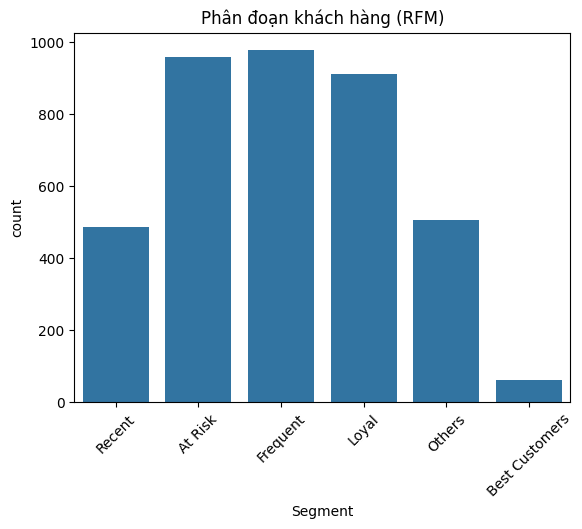

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Vẽ biểu đồ phân đoạn
sns.countplot(x='Segment', data=rfm_df)
plt.xticks(rotation=45)
plt.title('Phân đoạn khách hàng (RFM)')
plt.show()